In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

from skimage.feature import hog
from skimage.measure import label, regionprops

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
    GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

# Step 0 -- get data

In [2]:
# Create directory for training data
!mkdir -p data

In [3]:
# Get data
!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip -qO data/vehicles.zip
!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip -qO data/non-vehicles.zip

In [4]:
# Unzip data
!unzip -q data/vehicles.zip -d data
!rm -rf data/__MACOSX
!unzip -q data/non-vehicles.zip -d data
!rm -rf data/__MACOSX

In [2]:
# Get names of image files to estimate dataset sizes and then load images
images_vehicle = glob.glob('data/vehicles/*/*.png')
images_nonvehicle = glob.glob('data/non-vehicles/*/*.png')
print('Total vehicles: {}, Total non-vehicles: {}'.format(len(images_vehicle), len(images_nonvehicle)))

Total vehicles: 8792, Total non-vehicles: 8968


Deviation in class sizes is small so we can keep it without extra balancing

In [3]:
# load one sample image to get shape
sample_image = mpimg.imread(images_vehicle[0])

In [4]:
# get all images data
X = np.zeros((len(images_vehicle) + len(images_nonvehicle), *sample_image.shape), dtype=np.float32)
i = 0
for imgpath in images_vehicle:
    X[i] = mpimg.imread(imgpath)
    i += 1

for imgpath in images_nonvehicle:
    X[i] = mpimg.imread(imgpath)
    i += 1

In [6]:
# generate label data
y = np.hstack((np.ones(len(images_vehicle)), np.zeros(len(images_nonvehicle)))).astype(np.uint8)

In [7]:
# split into train, validation and test sets
RANDOM_STATE = 1234

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print('Train set shapes {}, {}'.format(X_TRAIN.shape, Y_TRAIN.shape))
print('Test set shapes {}, {}'.format(X_TEST.shape, Y_TEST.shape))

Train set shapes (14208, 64, 64, 3), (14208,)
Test set shapes (3552, 64, 64, 3), (3552,)


# Step 1 -- get features

In this step I basically define code snippets to perform HOG feature extraction. Detailed HOG parameters definition will be done later

In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [9]:
def draw_hog_examples(image, orient=12, pix_per_cell=6, cell_per_block=2):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls  = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    _, axarr = plt.subplots(1, 5, figsize=(12,3))
    axarr[0].set_title('original')
    axarr[0].imshow(image)
    
    _, gray_hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True)
    axarr[1].set_title('gray hog')
    axarr[1].imshow(gray_hog, cmap='gray')
    
    _, h_hog = get_hog_features(hls[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[2].set_title('H hog')
    axarr[2].imshow(h_hog, cmap='gray')
    
    _, l_hog = get_hog_features(hls[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[3].set_title('L hog')
    axarr[3].imshow(l_hog, cmap='gray')
    
    _, s_hog = get_hog_features(hls[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[4].set_title('S hog')
    axarr[4].imshow(s_hog, cmap='gray')

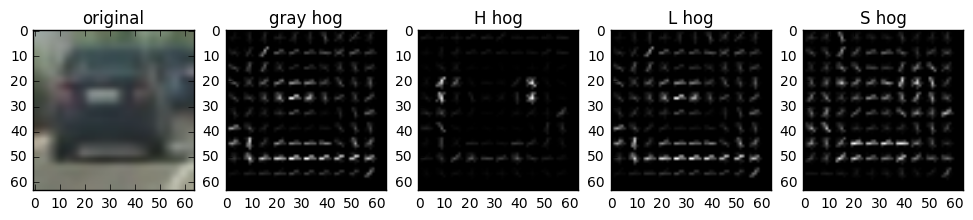

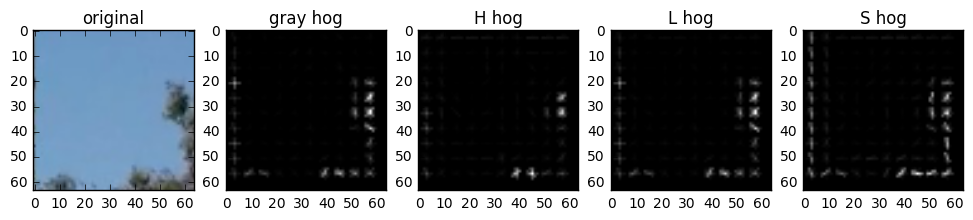

In [10]:
draw_hog_examples(mpimg.imread(images_vehicle[0]))
draw_hog_examples(mpimg.imread(images_nonvehicle[0]))

In [11]:
# This function takes dataset of images and returns dataset of features
def get_hog_data(X, colorspace, orient, pixpercell, cellperblock, featuresize):
    Xhog = np.zeros((X.shape[0], featuresize), dtype=np.float32)
    
    for idx in range(X.shape[0]):
        if colorspace == 'gray':
            x = cv2.cvtColor(X[idx], cv2.COLOR_RGB2GRAY)
        else:
            hls = cv2.cvtColor(X[idx], cv2.COLOR_RGB2HLS)
            x = hls[:,:,['h', 'l', 's'].index(colorspace)]
        
        f = get_hog_features(x, orient, pixpercell, cellperblock)
        Xhog[idx] = f
        
    return Xhog

# Step 2 -- train classifier

In this step I check several classifiers and HOG params to pick the best combination.

Classifiers to be tested:
* LinearSVC
* DecisionTreeClassifier,
* BaggingClassifier,
* ExtraTreesClassifier,
* GradientBoostingClassifier,
* RandomForestClassifier

In [12]:
classifiers = [
#     LinearSVC,
#     DecisionTreeClassifier,
#     BaggingClassifier,
#     ExtraTreesClassifier,
    GradientBoostingClassifier,
#     RandomForestClassifier
]

In [13]:
# This function is just for grid search
def examine_hog_params_and_classifiers(colorspace, orient, pixpercell, cellperblock):
    # get vector size, doesnt matter which color space to use
    sample_feature = get_hog_features(cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY), orient, pixpercell, cellperblock)
    vector_size = sample_feature.shape[0]
    
    # transform raw pixel data into hog features
    X_train = get_hog_data(X_TRAIN, colorspace, orient, pixpercell, cellperblock, vector_size)
    X_test =  get_hog_data(X_TEST,  colorspace, orient, pixpercell, cellperblock, vector_size)

    # get scaler from training data
    X_scaler = StandardScaler().fit(X_train)

    # transform all X data with scaler
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    print('colorspace {}, orient {}, pixpercell {}, cellperblock {}'.format(colorspace, orient, pixpercell, cellperblock))
    for c in classifiers:
        clf = c()
        clf.fit(X_train, Y_TRAIN)
        print(c, clf.score(X_test, Y_TEST))

Cell below was used to perform grid search and estimate best classifier and HOG params in terms of accuracy on test set

After my experiments I finished with next results:
* L-channel gives best results for HOG features, noteworthy is grayscale is also good
* GradientBoostingClassifier works best among other classifiers
* orient value of 10 gives best results
* more pixpercell produced more accuracy; best results I got with 16
* cells per block value of 2 gives best results

In [14]:
for colorspace in ['l']: # ['gray', 'h', 'l', 's']:
    for orient in [10]: # [6, 8, 10, 12]
        for pixpercell in [16]: # [4, 6, 8, 10, 12, 14, 16, 18, 20]:
            for cellperblock in [2]: # [1, 2, 3, 4]:
                examine_hog_params_and_classifiers(colorspace, orient, pixpercell, cellperblock)

colorspace l, orient 10, pixpercell 16, cellperblock 2
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> 0.975788288288


In [15]:
# Remember best params for further usage
HOG_ORIENT = 10
HOG_PPC = 16
HOG_CPB = 2
HOG_SIZE = 360

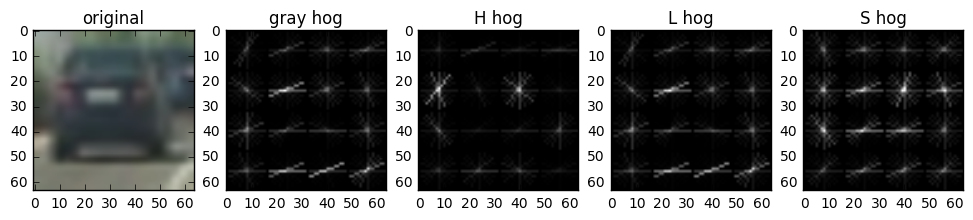

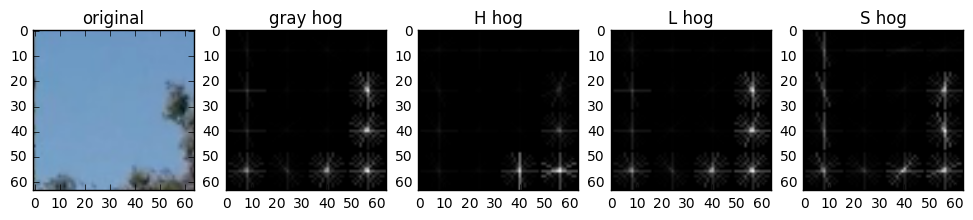

In [16]:
draw_hog_examples(mpimg.imread(images_vehicle[0]), HOG_ORIENT, HOG_PPC, HOG_CPB)
draw_hog_examples(mpimg.imread(images_nonvehicle[0]), HOG_ORIENT, HOG_PPC, HOG_CPB)

After features and classifier are defined, prepare scailer and trained classifier for future usage

In [17]:
X_train = get_hog_data(X_TRAIN, 'l', HOG_ORIENT, HOG_PPC, HOG_CPB, HOG_SIZE)
X_scaler = StandardScaler().fit(X_train)

In [18]:
def preprocess_input(X):
    X = get_hog_data(X, 'l', HOG_ORIENT, HOG_PPC, HOG_CPB, HOG_SIZE)
    X = X_scaler.transform(X)
    return X

In [19]:
X_train = preprocess_input(X_TRAIN)
X_test =  preprocess_input(X_TEST)
clf = GradientBoostingClassifier()
clf.fit(X_train, Y_TRAIN)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [20]:
# Confirm evaluation results
print(clf.score(X_train, Y_TRAIN), clf.score(X_test, Y_TEST))

0.986204954955 0.975788288288


# Step 3 -- sliding window search

In [21]:
# These are manually defined parameters for sliding windows found after many tests

IMG_WIDTH = 1280
IMG_HEIGTH = 720
IMG_CENTER = 640
SLW_OVERLAP = .05
SLW_WINDOWS = [
    (96,  256),
    (150, 196),
    (200, 128),
    (230, 96),
]

My sliding window approach uses non-linear sizes. Common idea is next:
* take initial window size, e.g. 96 pixels
* define center position of the window based on initial window size and overlap factor
* use height same as window size, e.g. 96 pixels
* calculate width with next formula:
  + $Size_{new} = Size_{default} * (1 + (\frac{center_{window} - center_{image}}{0.5 * Size_{image}})^2)$
  + i.e. if window is far left/right from center, use more rectangled window, because of perspective

In [22]:
def get_sliding_windows(img):
    windows = []
    images = []
    
    # For every defined sliding window
    for bottom_offset, window_size in SLW_WINDOWS:
        # Define step and total number of windows
        step = int(window_size * SLW_OVERLAP)
        total_windows = IMG_WIDTH // step + 1
        
        # For every single window
        for i in range(total_windows):
            # Define center and window width
            center = i * step
            deviation = float(center - IMG_CENTER) / IMG_CENTER
            window_width = int((window_size / 2) * (1. + deviation ** 2))
            
            # Calculate left and right X positions
            if center - window_width < 0:
                xleft = 0
                xrigh = center + window_width
            elif center + window_width > IMG_WIDTH:
                xleft = center - window_width
                xrigh = IMG_WIDTH
            else:
                xleft = center - window_width
                xrigh = center + window_width
                
            # Calculate Y positions
            yleft = IMG_HEIGTH - bottom_offset
            yrigh = yleft - window_size
            
            # Remember box coordinates and image patch
            windows.append([(xleft, yleft), (xrigh, yrigh)])
            images.append(img[yrigh:yleft, xleft:xrigh, :])
            
    return windows, images

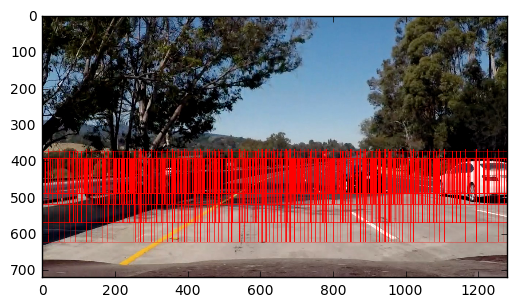

In [23]:
# Just visualize how sliding window look like
test_img = mpimg.imread('test_images/test5.jpg')
windows, _ = get_sliding_windows(test_img)
for p1, p2 in windows:
    cv2.rectangle(test_img, p1, p2, (255,0,0), 1)
plt.imshow(test_img)

In [24]:
# If image patch is not 64x64, resize it
def prepare_image_patch_for_classifier(img):
    if img.shape[0] != 64 or img.shape[1] != 64:
        img = cv2.resize(img, (64, 64))
    img = np.expand_dims(img, axis=0)
        
    return img

In [25]:
# Get heatmap of positive detections
def get_vehicles_heatmap_from_image(source_image, probability=.85):
    # Get all sliding windows and image patches
    windows, images = get_sliding_windows(source_image)
    
    # Define heatmap as zeros image
    heatmap = np.zeros((source_image.shape[0], source_image.shape[1]), dtype=np.uint8)
    
    i = 0
    for i in range(len(windows)):
        wnd, img = windows[i], images[i]
        
        # Preprocess image patch
        img = prepare_image_patch_for_classifier(img)
        img = preprocess_input(img)
        
        # Classify, but take not 0 or 1 class prediction, but raw probability
        clfproba = clf.predict_proba(img)[0]
        
        # Only if probability is high enouth, consider patch as vehicle and update heatmap
        if clfproba[1] > probability:
            xleft, yleft = wnd[0]
            xrigh, yrigh = wnd[1]
            heatmap[yrigh:yleft, xleft:xrigh] += 1

    return heatmap

Important part here -- merge overlapped windows into one by using [`skimage.measure.label`](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) and [`skimage.measure.regionprops`](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) functions

In [26]:
# Take boundary boxes from a heatmap of positive detections
def get_boundaries_from_heatmap(heatmap):
    # If heatmap is empty, return empty boundaries
    if(heatmap.max() == 0):
        return []
    
    # Consider only heatmap valies greater than 1
    thresh = 1
    mask = np.zeros_like(heatmap)
    mask[heatmap > thresh] = 1
    
    # Use skimage.measure.label to label regions on the mask
    labeled = label(mask)
    boxes = []
    
    # Use skimage.measure.regionprops to get regois our of labelled image. Keep only images with big area
    for region in regionprops(labeled):
        if region.area < 5000:
            continue
        
        minr, minc, maxr, maxc = region.bbox
        boxes.append(((minc, minr), (maxc, maxr)))
    return boxes

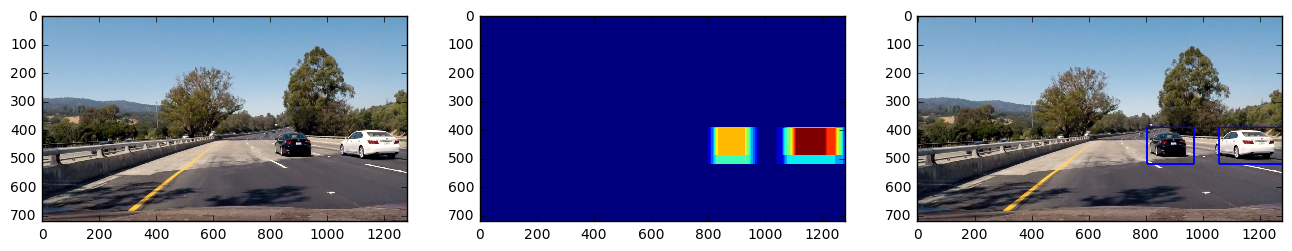

In [27]:
# Visualization
testimg = mpimg.imread('test_images/test4.jpg')
testimg_out = np.copy(testimg)
heatmap = get_vehicles_heatmap_from_image(testimg)
boxes = get_boundaries_from_heatmap(heatmap)
for box in boxes:
    p1, p2 = box
    cv2.rectangle(testimg_out, p1, p2, (0,0,255), 3)

_, axarr = plt.subplots(1, 3, figsize=(16,5))
axarr[0].imshow(testimg)
axarr[1].imshow(heatmap)
axarr[2].imshow(testimg_out)

# Step 4 -- video processing and false positives elimination

To get rid of false positives on the video I keep tracking centroid of detected boxes.
On every frame the logic is next:
* get boxes with sliding window
* for every found box calculate centroid
* use centroid trackers to define if current centroid belongs to already tracked vehicle
* if no tracker matched this centroid, create new tracker
* **draw box only if tracker has several successful centroids** -- this is the most important part of getting rid of false positives. Tracked vehicles will pass this condition successfully and draw boxes, but false positive trackers will fail and die soon

As noted, if tracker has no new detections for several steps (DEATH_TOLERANCE), it will be considered as dead and removed

Thus, only correct vehicle tracking trackers will survive and draw boxes from frame to frame

In [28]:
# Centroid class for easier handling of centroid information
class Centroid():
    
    CLOSENESS_DISTANCE = 50
    
    def __init__(self, coords=None):
        self.coords = coords
        
    def init_from_box(self, box):
        p1, p2 = box
        x = int((p1[0] + p2[0]) / 2)
        y = int((p1[1] + p2[1]) / 2)
        self.coords = (x, y)
        
    def get_distance_to_centroid(self, centroid):
        x1, y1 = self.coords
        x2, y2 = centroid.coords
        return np.sqrt((x1-x2)**2 + (y1-y2)**2)

    def is_close_to_centroid(self, centroid):
        return self.get_distance_to_centroid(centroid) < self.CLOSENESS_DISTANCE

In [29]:
# CentroidTracker is used to handle and store centroids data as well as tracker state itself
class CentroidTracker():
    
    # If 3 of 8 last frames have detections,last centroid is fine to draw
    DRAWABLE_SIZE = 8
    DRAWABLE_TRESHOLD = 3
    
    # If 5 of 15 last frames have detections and no new box found on this frame
    # it is ok to restore last box and use as current frame
    RESTORABLE_SIZE = 15
    RESTORABLE_TRESHOLD = 5
    
    # If last 10 frames have no detection, consider tracker as dead and remove
    DEATH_TOLERANCE = 10
    
    # Max number of history
    MAX_HISTORY = 15
    
    def __init__(self, centroid):
        self.centroids = [centroid]
        
        self.last_box = None
        self.detected = False
        self.detections = []
        
    # True if new centroid is close to last one of this tracker
    def check_new_centroid(self, centroid):
        if self.detected:
            return False
        
        last_centroid = self.centroids[-1]
        is_close_to_last = centroid.is_close_to_centroid(last_centroid)
        return is_close_to_last
    
    # Append new centroid if it matches current tracker
    def append_centroid(self, centroid):
        if self.check_new_centroid(centroid):
            self.centroids.append(centroid)
            self.detected = True
            return True
        return False
    
    # True if tracker has enough detections
    def is_last_centroid_drawable(self):
        n_last_detections = np.array(self.detections[-self.DRAWABLE_SIZE:]).sum()
        return n_last_detections >= self.DRAWABLE_TRESHOLD
    
    # True if tracker has enough detections in its lifetime
    def is_restorable(self):
        if len(self.detections) < self.RESTORABLE_SIZE:
            return False
        
        n_last_detections = np.array(self.detections[-self.RESTORABLE_SIZE:]).sum()
        return n_last_detections >= self.RESTORABLE_TRESHOLD
    
    # True if tracker has no detections for last DEATH_TOLERANCE frames
    def is_dead(self):
        # A young tracker is not yet dead
        if len(self.detections) < self.DEATH_TOLERANCE:
            return False
        
        last_steps = self.detections[-self.DEATH_TOLERANCE:]
        is_dead = not np.array(last_steps).any()
        return is_dead
    
    # Keep last detected box
    def set_last_box(self, box):
        self.last_box = box
    
    # Reset tracker detection state in the beginning of every frame
    def pre_frame_action(self):
        self.detected = False
    
    # Keep limited history
    def post_frame_action(self):
        self.detections.append(self.detected)
        self.detections = self.detections[-self.MAX_HISTORY:]
        self.centroids  = self.centroids[-self.MAX_HISTORY:]

In [30]:
# ImageProcessor for handling trackers and processing the image
class ImageProcessor():
    
    def __init__(self):
        self.trackers = []
        self.current_frame = None
        
    # Set current frame as a copy of incoming frame
    def set_frame(self, frame):
        self.current_frame = np.copy(frame)
        
    # Draw rectangle
    def draw_box_on_frame(self, box):
        p1, p2 = box
        cv2.rectangle(self.current_frame, p1, p2, (0,0,255), 3)
        
    # Calculate weighted rectangle to prevent big shape shaking
    def get_averaged_box(self, box1, box2):
        a1, a2 = box1
        b1, b2 = box2
        a1, a2, b1, b2 = np.array(a1), np.array(a2), np.array(b1), np.array(b2)
        
        avg1 = 0.9 * a1 + 0.1 * b1
        avg2 = 0.9 * a2 + 0.1 * b2
        
        result_box = ((int(avg1[0]), int(avg1[1])), (int(avg2[0]), int(avg2[1])))
        return result_box
        
    # Pre-frame trackers handler
    def pre_frame_action(self):
        for t in self.trackers:
            t.pre_frame_action()
        
    # Post-frame trackers handler
    def post_frame_action(self):
        alive_trackers = []
        for t in self.trackers:
            t.post_frame_action()
            
            # if tracker is dead (i.e. has no detectins), get rid of it
            if not t.is_dead():
                alive_trackers.append(t)
        self.trackers = alive_trackers
        
    # Main frame processing function
    def process_frame(self):
        # First, get boxes from current image
        heatmap = get_vehicles_heatmap_from_image(self.current_frame)
        boxes = get_boundaries_from_heatmap(heatmap)
        
        # reset tracker states before frame processing
        self.pre_frame_action()
        
        # check every found box
        for box in boxes:
            # get centroid
            c = Centroid()
            c.init_from_box(box)
            
            # by default, centroid is considered as a trash
            frame_box = None
            is_assigned = False
            is_drawable = False
            
            # try current centroid for every tracker to see which one it can match
            for tracker in self.trackers:
                # if matches, append to that tracker and check if it is drawable
                if tracker.check_new_centroid(c):
                    tracker.append_centroid(c)
                    
                    frame_box = box
                    if (tracker.last_box):
                        frame_box = self.get_averaged_box(tracker.last_box, frame_box)
                    tracker.set_last_box(frame_box)
                    
                    is_assigned = True
                    is_drawable = tracker.is_last_centroid_drawable()
                    break
                    
            # not matched to any tracker -- maybe a new car appeared on the road?
            if not is_assigned:
                newtracker = CentroidTracker(c)
                self.trackers.append(newtracker)
                
            if is_drawable:
                self.draw_box_on_frame(frame_box)
        
        # If no boxes found, check if any tracker is good enough to be restored
        if not len(boxes):
            for t in self.trackers:
                if t.is_restorable():
                    self.draw_box_on_frame(t.last_box)
                
        self.post_frame_action()
        return self.current_frame

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
IP = ImageProcessor()

def process_image(image):
    IP.set_frame(image)
    return IP.process_frame()



from moviepy.editor import VideoFileClip

project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_image) 
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [14:52<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 14min 53s


In [35]:
# Showtime!
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(white_output))